In [28]:
import numpy
import numpy as np
import pandas
import os
import sys
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
import pandas as pd
from scipy.optimize import curve_fit

In [20]:
def progress_iterable_condition(inp_data):
    try:
        assert type(inp_data) == numpy.ndarray or type(inp_data) == pandas.core.frame.DataFrame or type(
            inp_data) == pandas.core.series.Series or type(inp_data) == list or type(
            inp_data) == pandas.core.indexes.range.RangeIndex or type(inp_data) == pandas.core.indexes.base.Index
        if type(inp_data) == pandas.core.frame.DataFrame or type(inp_data) == numpy.ndarray:
            assert len(inp_data.shape) == 1
            if type(inp_data) == pandas.core.frame.DataFrame:
                inp_data2 = inp_data.values
            else:
                inp_data2 = inp_data[:]
        else:
            try:
                assert len(inp_data[0]) > 0
            except:
                if type(inp_data) == pandas.core.series.Series:
                    inp_data2 = inp_data.values
                else:
                    inp_data2 = inp_data[:]
        return True, inp_data2
    except Exception as e:
        if e.__traceback__.tb_lineno == 3:
            print('input data must a pandas Dataframe or Series or numpy array or list ')
        elif e.__traceback__.tb_lineno == 7:
            print('input data must have 1 dimension')
        elif e.__traceback__.tb_lineno == 14:
            print('your list must have 1 dimension')
        print(e.__traceback__.tb_lineno, e.__str__(), e)
        return False, False

In [21]:
def ARC(inp_data1, inp_data2):
    try:
        assert type(inp_data1) == type(inp_data2)
        p1 = progress_iterable_condition(inp_data1)
        p2 = progress_iterable_condition(inp_data2)
        assert p1[0]
        assert p2[0]
        assert len(inp_data1) == len(inp_data2)
        arc = []
        for i in range(2, len(p1[1])):
            arc.append(numpy.corrcoef(p1[1][0:i], p2[1][0:i])[0][1])
        return numpy.array(arc)
    except Exception as e:
        print(e.__traceback__.tb_lineno, e.__str__(), e)

In [22]:
def cor_during_time(inp_data1, inp_data2, time_period):
    try:
        assert type(inp_data1) == type(inp_data2)
        p1 = progress_iterable_condition(inp_data1)
        p2 = progress_iterable_condition(inp_data2)
        assert p1[0]
        assert p2[0]
        assert len(inp_data1) == len(inp_data2)
        c_d_t = []
        for i in range(len(p1[1]) - time_period):
            c_d_t.append(numpy.corrcoef(p1[1][i:i + time_period], p2[1][i:i + time_period])[0][1])
        return numpy.array(c_d_t)
    except Exception as e:
        print(e.__traceback__.tb_lineno, e.__str__(), e)

In [23]:
def intersect(inp_data1, inp_data2):
    try:
        assert type(inp_data1) == type(inp_data2)
        p1 = progress_iterable_condition(inp_data1)
        p2 = progress_iterable_condition(inp_data2)
        assert p1[0]
        sect = []
        if len(p1[1]) > len(p2[1]):
            #print(1)
            for i in p1[1]:
                if i in p2[1]:
                    sect.append(i)

        else:

            for i in p2[1]:
                if i in p1[1]:
                    sect.append(i)

        return numpy.array(sect)
    except Exception as e:
        print(e.__traceback__.tb_lineno, e.__str__(), e)

In [24]:
def exp_change(inp_columns):
    try:
        p1 = progress_iterable_condition(inp_columns)
        assert p1[0]
        inp_columns2 = p1[1]
        exp_change_dt = []
        first = 0
        for i in range(len(inp_columns2)):
            if first == 0:
                if str(inp_columns2[i]) != 'nan':
                    first = i
                    break

        j = first
        k = first + 1
        for i in range(first, len(inp_columns) - 1):
            if str(inp_columns2[j]) != 'nan' and str(inp_columns2[k]) != 'nan':
                if k - j == 1:
                    exp_change_dt.append(inp_columns2[k] / inp_columns2[j])
                    j += 1
                    k += 1
                elif k - j > 1:
                    exp_change_dt.append((inp_columns2[k] / inp_columns2[j]) ** (1 / (k - j)))
                    j = k
                    k += 1
            elif str(inp_columns2[j]) != 'nan' and str(inp_columns2[k]) == 'nan':
                k += 1
        return numpy.array(exp_change_dt)
    except Exception as e:
        print(e.__traceback__.tb_lineno, e.__str__(), e)


In [25]:
def key_points(inp_x, inp_y, point_num: int, max_iter: int):
    all_errors = []
    min_s = numpy.inf
    selected_point = []
    p_x = progress_iterable_condition(inp_x)
    p_y = progress_iterable_condition(inp_y)
    assert p_x[0] and p_y[0]
    x = p_x[1]
    y = p_y[1]
    for i in range(2, point_num):
        all_err = []
        for j in range(max_iter):
            choices_x1 = np.random.choice(x, i)
            choices_y1 = y[choices_x1]
            f_7 = interp1d(choices_x1, choices_y1)
            range_choice1 = (np.min(choices_x1), np.max(choices_x1))
            x_7 = (x / np.max(x)) * (range_choice1[1] - range_choice1[0]) + range_choice1[0]
            y_7 = f_7(x_7)
            mse = mean_squared_error(y, y_7)
            all_err.append(mse)
            if mse < min_s:
                min_s = mse
                selected_point = choices_x1
        all_errors.append(all_err)
    return all_errors, min_s, selected_point

In [26]:
def auto_interpolation_fit(inp_x, inp_y):
    p_x = progress_iterable_condition(inp_x)
    p_y = progress_iterable_condition(inp_y)
    assert p_x[0] and p_y[0]
    x = p_x[1]
    y = p_y[1]
    mse = numpy.zeros(shape=(len(x),))
    for i in range(2, len(x)):
        f_2 = interp1d(x[:i + 1], y[:i + 1])
        x_2 = x / (len(x) / i)
        y_2 = f_2(x_2)
        mse[i] = (mean_squared_error(y, y_2))
    return mse

In [27]:
def key_index(inp_data, point_num: int, max_iter: int):
    p1 = progress_iterable_condition(inp_data)
    y1 = p1[1]
    x1 = numpy.arange(0, len(y1))
    return key_points(x1, y1, point_num, max_iter)[2]

In [28]:
def sample_fractal_on_alldata(inp_x, inp_y):
    p_x = progress_iterable_condition(inp_x)
    p_y = progress_iterable_condition(inp_y)
    assert p_x[0] and p_y[0]
    x = p_x[1]
    y = p_y[1]
    all_mse = []
    for i in range(2, len(y)):
        mse3 = []
        for j in range(0, len(x) - i):
            f_4 = interp1d(x[j:j + i + 1], y[j:j + i + 1])
            x_4 = ((x / np.max(x)) * i) + j
            z_2 = f_4(x_4)
            y_4 = (z_2 / np.max(z_2)) * np.max(y)
            mse3.append(mean_squared_error(y, y_4))
        all_mse.append(mse3)
    return all_mse

In [29]:
def build_from_sample_alldata(inp_x, inp_y, all_x, all_y, kind=None):
    px = progress_iterable_condition(inp_x)
    py = progress_iterable_condition(inp_y)
    pxa = progress_iterable_condition(all_x)
    pya = progress_iterable_condition(all_y)
    assert px[0] and py[0] and pxa[0] and pya[0]
    x_sample = px[1]
    y_sample = py[1]
    x_all = pxa[1]
    y_all = pya[1]
    f_1 = interp1d(x_sample, y_sample)
    range_xs = (numpy.min(x_sample), numpy.max(x_sample))
    tr_x = ((x_all / numpy.max(x_all)) * (range_xs[1] - range_xs[0])) + range_xs[0]
    if kind == 'adj':
        tr_y = (f_1(tr_x) / numpy.max(f_1(tr_x))) * numpy.max(all_y)
    else:
        tr_y = f_1(tr_x)
    return tr_y

In [35]:
def mean_exp(inp_column):
    """calculate mean geometric of an return series"""
    try:
        p1 = progress_iterable_condition(inp_column)
        assert p1[0]
        inp_column2 = p1[1]
        ex = 1
        for i in inp_column2:
            ex *= i
        return ex ** (1 / len(inp_column))
    except Exception as e:
        print(e.__traceback__.tb_lineno, e.__str__(), e)

In [7]:
#type([]) == list

In [8]:
#numpy.random.randint(0, 100, 1000)[0:100]

In [9]:
#a = pandas.DataFrame(numpy.random.randint(0, 100, (5, 5)))
#a

In [10]:
#type(a) == pandas.core.frame.DataFrame

In [11]:
#len(a.shape)

In [12]:
#type(a[0])

In [13]:
#a.iloc[:, :2]

In [14]:
#type(a.index)

In [15]:
#a.index = ['a', 'b', 'c', 'd', 'e']

In [16]:
#type(a.index)

In [17]:
#b = numpy.array([])

In [18]:
#for i in range(100):
#    b.resize((b.shape[0] + 1,))
#    b.put(-1, i)

In [19]:
#b

In [20]:
#c = [i for i in range(100)]

In [21]:
#sys.getsizeof(b)

In [22]:
#sys.getsizeof(c)

In [2]:
import finpy_tse as tse
import yfinance as yf

In [4]:
a = tse.get_price_history('فزر', ignore_date=True, double_date=True)

In [5]:
a

,Date,Open,High,Low,Close,Final,Volume,Value,No,Ticker,Name,Market
J-Date,,,,,,,,,,,,
1400-11-20,2022-02-09,17726,21666,17726,17800,21429,299999591,6428779475028,1264932,فزر,پویا زرکان آق دره,فرابورس
1400-11-23,2022-02-12,22500,22500,22500,22500,22500,5647336,127065060000,29757,فزر,پویا زرکان آق دره,فرابورس
1400-11-24,2022-02-13,23600,23600,23600,23600,23600,8205025,193638590000,34375,فزر,پویا زرکان آق دره,فرابورس
1400-11-25,2022-02-14,24750,24750,24750,24750,24750,8782700,217371825000,38520,فزر,پویا زرکان آق دره,فرابورس
1400-11-27,2022-02-16,25950,25950,24850,25300,25700,129477173,3326995414950,526252,فزر,پویا زرکان آق دره,فرابورس
...,...,...,...,...,...,...,...,...,...,...,...,...
1402-12-09,2024-02-28,39850,40700,39750,39800,39900,4355890,173818112250,2219,فزر,پویا زرکان آق دره,فرابورس
1402-12-12,2024-03-02,40150,42650,40150,42650,41800,7903260,330312984600,2508,فزر,پویا زرکان آق دره,فرابورس
1402-12-13,2024-03-03,43000,43850,41950,42100,42600,6532632,278300586750,2961,فزر,پویا زرکان آق دره,فرابورس


In [27]:
b = yf.download('GC=F', interval='1D')

[*********************100%%**********************]  1 of 1 completed


In [28]:
#b

In [29]:
b.reset_index(inplace=True)

In [30]:
b

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0
1,2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0
2,2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0
3,2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2
4,2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0
...,...,...,...,...,...,...,...
5888,2024-02-19,2015.599976,2015.599976,2015.599976,2015.599976,2015.599976,32
5889,2024-02-20,2015.599976,2029.000000,2015.599976,2027.500000,2027.500000,1326
5890,2024-02-21,2028.199951,2028.199951,2022.300049,2022.300049,2022.300049,15
5891,2024-02-22,2033.199951,2033.199951,2019.699951,2019.699951,2019.699951,964


In [31]:
#a.Date[0]

In [32]:
#b.Date[0]

In [33]:
ind = intersect(b.Date.values, a.Date.values)

In [34]:
#ind

In [35]:
a.index = a.Date
b.index = b.Date

In [36]:
a_sect = a.loc[ind, :]
b_sect = b.loc[ind, :]

In [37]:
a_sect

,Date,Open,High,Low,Close,Final,Volume,Value,No,Ticker,Name,Market
Date,,,,,,,,,,,,
2022-02-09,2022-02-09,17726,21666,17726,17800,21429,299999591,6428779475028,1264932,فزر,پویا زرکان آق دره,فرابورس
2022-02-14,2022-02-14,24750,24750,24750,24750,24750,8782700,217371825000,38520,فزر,پویا زرکان آق دره,فرابورس
2022-02-16,2022-02-16,25950,25950,24850,25300,25700,129477173,3326995414950,526252,فزر,پویا زرکان آق دره,فرابورس
2022-02-22,2022-02-22,27500,27500,25700,26800,26600,37125603,987770396550,49793,فزر,پویا زرکان آق دره,فرابورس
2022-02-23,2022-02-23,27100,27900,26600,27900,27650,27198007,752457380300,36475,فزر,پویا زرکان آق دره,فرابورس
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-06,2024-02-06,48450,48500,48050,48350,48300,3226785,155781413700,1589,فزر,پویا زرکان آق دره,فرابورس
2024-02-07,2024-02-07,48500,49850,48300,49750,48900,5218395,255286379950,1936,فزر,پویا زرکان آق دره,فرابورس
2024-02-19,2024-02-19,42000,42700,41600,41900,42050,7041926,295990700150,2775,فزر,پویا زرکان آق دره,فرابورس


In [38]:
b_sect

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2022-02-09,2022-02-09,1825.400024,1835.199951,1825.300049,1835.199951,1835.199951,683
2022-02-14,2022-02-14,1861.800049,1870.599976,1854.599976,1868.000000,1868.000000,79
2022-02-16,2022-02-16,1858.699951,1870.199951,1856.300049,1870.199951,1870.199951,34
2022-02-22,2022-02-22,1908.099976,1912.000000,1890.800049,1906.099976,1906.099976,173
2022-02-23,2022-02-23,1896.599976,1910.599976,1895.699951,1909.199951,1909.199951,73
...,...,...,...,...,...,...,...
2024-02-06,2024-02-06,2025.900024,2037.300049,2025.900024,2034.500000,2034.500000,249
2024-02-07,2024-02-07,2032.800049,2039.500000,2032.699951,2035.199951,2035.199951,71
2024-02-19,2024-02-19,2015.599976,2015.599976,2015.599976,2015.599976,2015.599976,32


In [39]:
ARC(a_sect.Close.values, b_sect.Close.values)

array([ 1.        ,  0.99995307,  0.90654457,  0.92668405,  0.92235773,
        0.90550497,  0.60379451,  0.57260657,  0.6007169 ,  0.61278403,
        0.60931328,  0.60235092,  0.5877803 ,  0.5849941 ,  0.57701065,
        0.56417493,  0.55824659,  0.56384341,  0.55677463,  0.55762549,
        0.56700093,  0.57186438,  0.57543617,  0.50771486,  0.43984942,
        0.36922599,  0.27682965,  0.14344991,  0.00181777, -0.10648589,
       -0.22820868, -0.31635157, -0.39049332, -0.39176623, -0.38036693,
       -0.36428033, -0.3465577 , -0.31422132, -0.2988939 , -0.28968938,
       -0.29666413, -0.28776353, -0.27531679, -0.26658706, -0.2530813 ,
       -0.22589188, -0.2006593 , -0.1743598 , -0.12448448, -0.06047985,
        0.01705716,  0.07890608,  0.12614863,  0.17909534,  0.22189925,
        0.27084212,  0.30876294,  0.33975033,  0.35962139,  0.37044194,
        0.37973498,  0.39209469,  0.40538681,  0.42628232,  0.44263413,
        0.45711601,  0.46892012,  0.48194614,  0.49580665,  0.50

In [40]:
import matplotlib.pyplot as plt

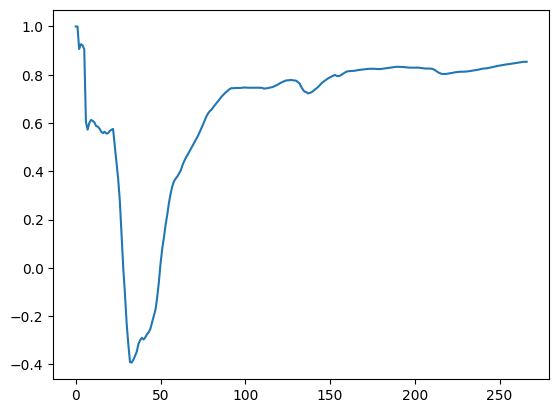

In [41]:
plt.plot(ARC(a_sect.Close.values, b_sect.Close.values))

In [42]:
cor_during_time(a_sect.Close.values, b_sect.Close.values, 20)

array([ 0.55677463,  0.35596204,  0.21621302, -0.05758576, -0.1766975 ,
       -0.35063832, -0.40541732, -0.52072242, -0.56076267, -0.69623176,
       -0.78248692, -0.79358879, -0.84526874, -0.90454206, -0.9304746 ,
       -0.90633755, -0.8370956 , -0.7588468 , -0.68235271, -0.5680985 ,
       -0.48227071, -0.42106602, -0.39237403, -0.29652681, -0.17724307,
       -0.14971802, -0.18000423, -0.14726233, -0.09821186, -0.09780955,
        0.08220464,  0.17609354,  0.38983948,  0.55041395,  0.84334602,
        0.85643207,  0.86145194,  0.86381336,  0.8710516 ,  0.89389817,
        0.85190969,  0.78541344,  0.72361025,  0.67865836,  0.6262604 ,
        0.5624767 ,  0.44947192,  0.33636923,  0.15137102, -0.16729648,
       -0.30392294, -0.32081986, -0.30124874, -0.21553016, -0.13537962,
        0.09920908,  0.44779311,  0.5742621 ,  0.66175883,  0.76796069,
        0.80035227,  0.77315532,  0.69140344,  0.70251842,  0.70138637,
        0.70824467,  0.7227719 ,  0.73266067,  0.70725063,  0.68

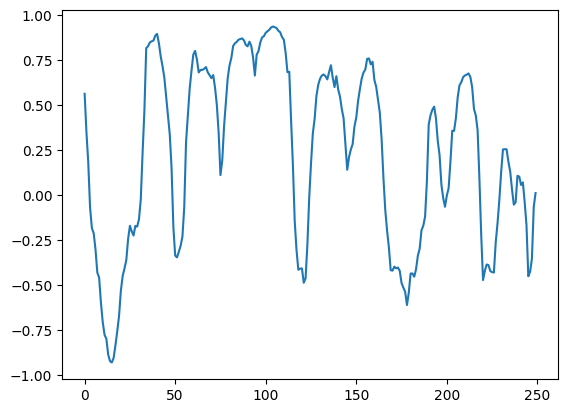

In [43]:
plt.plot(cor_during_time(a_sect.Close.values, b_sect.Close.values, 19))

In [44]:
c = b['Open'].reset_index()

In [45]:
c

,Date,Open
0,2000-08-30,273.899994
1,2000-08-31,274.799988
2,2000-09-01,277.000000
3,2000-09-05,275.799988
4,2000-09-06,274.200012
...,...,...
5888,2024-02-19,2015.599976
5889,2024-02-20,2015.599976
5890,2024-02-21,2028.199951
5891,2024-02-22,2033.199951


In [46]:
exp_change(b['Close'])

array([1.01606424, 0.99532883, 0.99566783, ..., 0.99743529, 0.99871429,
       1.01292276])

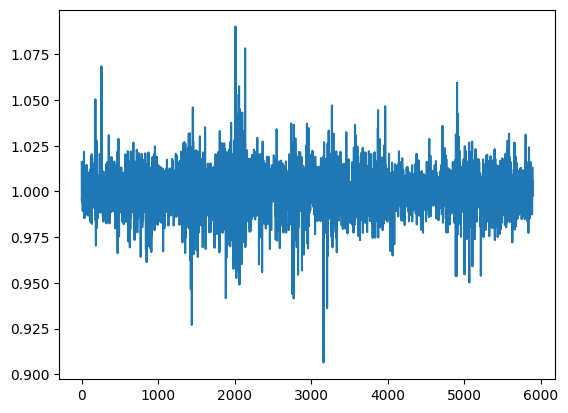

In [47]:
plt.plot(exp_change(b['Close'].values))

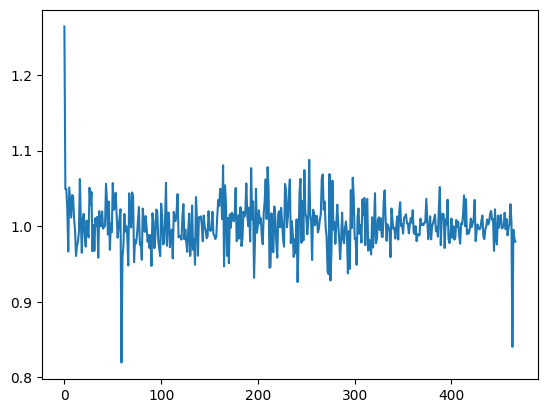

In [48]:
plt.plot(exp_change(a['Close']))

In [49]:
def mean_exp(inp_column):
    try:
        p1 = progress_iterable_condition(inp_column)
        assert p1[0]
        inp_column2 = p1[1]
        ex = 1
        for i in inp_column2:
            ex *= i
        return ex ** (1 / len(inp_column))
    except Exception as e:
        print(e.__traceback__.tb_lineno, e.__str__(), e)

In [50]:
c.values

array([[Timestamp('2000-08-30 00:00:00'), 273.8999938964844],
       [Timestamp('2000-08-31 00:00:00'), 274.79998779296875],
       [Timestamp('2000-09-01 00:00:00'), 277.0],
       ...,
       [Timestamp('2024-02-21 00:00:00'), 2028.199951171875],
       [Timestamp('2024-02-22 00:00:00'), 2033.199951171875],
       [Timestamp('2024-02-23 00:00:00'), 2034.0999755859375]],
      dtype=object)

In [51]:
mean_exp(exp_change(a['Close']))

1.0017566402907787

In [52]:
progress_iterable_condition(c)

input data must have 1 dimension
7  


False

In [53]:
#len(c.values)

In [54]:
#c.values[0]

In [55]:
#c.values[0, 0]

In [56]:
#c.values[0, 1]

In [32]:
def build_exp_smooth_trend(inp_dataframe):
    assert type(inp_dataframe) == pandas.core.frame.DataFrame or type(inp_dataframe) == numpy.ndarray or type(
        inp_dataframe) == list
    if type(inp_dataframe) == pandas.core.frame.DataFrame or type(inp_dataframe) == numpy.ndarray:
        assert len(inp_dataframe.shape) == 2
        if type(inp_dataframe) == pandas.core.frame.DataFrame:
            inp_dataframe2 = inp_dataframe.values
        else:
            inp_dataframe2 = inp_dataframe[:]
    else:
        assert len(inp_dataframe[0]) > 1
        inp_dataframe2 = numpy.array(inp_dataframe)
    return_data = numpy.array([exp_change(inp_dataframe2[:, i]) for i in range(inp_dataframe2.shape[1])]).T
    mean_return_data = numpy.array([mean_exp(return_data[:, i]) for i in range(return_data.shape[1])])
    expected_data = pandas.DataFrame([])
    for i in range(inp_dataframe2.shape[1]):
        expected_data[i] = numpy.array(
            [inp_dataframe2[0, i] * (mean_return_data[i] ** j) for j in range(inp_dataframe2.shape[0])])
    return expected_data

In [58]:
b_sect

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2022-02-09,2022-02-09,1825.400024,1835.199951,1825.300049,1835.199951,1835.199951,683
2022-02-14,2022-02-14,1861.800049,1870.599976,1854.599976,1868.000000,1868.000000,79
2022-02-16,2022-02-16,1858.699951,1870.199951,1856.300049,1870.199951,1870.199951,34
2022-02-22,2022-02-22,1908.099976,1912.000000,1890.800049,1906.099976,1906.099976,173
2022-02-23,2022-02-23,1896.599976,1910.599976,1895.699951,1909.199951,1909.199951,73
...,...,...,...,...,...,...,...
2024-02-06,2024-02-06,2025.900024,2037.300049,2025.900024,2034.500000,2034.500000,249
2024-02-07,2024-02-07,2032.800049,2039.500000,2032.699951,2035.199951,2035.199951,71
2024-02-19,2024-02-19,2015.599976,2015.599976,2015.599976,2015.599976,2015.599976,32


In [59]:
b_sect.loc[:, ['Open', 'High', 'Low', 'Close']].values

array([[1825.40002441, 1835.19995117, 1825.30004883, 1835.19995117],
       [1861.80004883, 1870.59997559, 1854.59997559, 1868.        ],
       [1858.69995117, 1870.19995117, 1856.30004883, 1870.19995117],
       ...,
       [2015.59997559, 2015.59997559, 2015.59997559, 2015.59997559],
       [2015.59997559, 2029.        , 2015.59997559, 2027.5       ],
       [2028.19995117, 2028.19995117, 2022.30004883, 2022.30004883]])

In [60]:
b_sect.loc[:, ['Open', 'High', 'Low', 'Close']].values[:, 0]

array([1825.40002441, 1861.80004883, 1858.69995117, 1908.09997559,
       1896.59997559, 1928.30004883, 1945.59997559, 1989.        ,
       1999.40002441, 2053.60009766, 1976.5       , 1939.80004883,
       1922.40002441, 1893.5       , 1918.40002441, 1921.19995117,
       1927.09997559, 1916.69995117, 1946.59997559, 1952.5       ,
       1969.5       , 1973.40002441, 1973.80004883, 1945.5       ,
       1925.        , 1900.5       , 1897.80004883, 1896.69995117,
       1866.59997559, 1839.90002441, 1841.5       , 1790.5       ,
       1824.90002441, 1815.        , 1852.5       , 1846.19995117,
       1850.30004883, 1831.        , 1849.        , 1836.90002441,
       1844.80004883, 1873.80004883, 1825.        , 1814.09997559,
       1835.30004883, 1829.5       , 1830.5       , 1824.19995117,
       1818.30004883, 1805.40002441, 1762.5       , 1732.5       ,
       1734.19995117, 1710.        , 1712.30004883, 1707.09997559,
       1727.        , 1718.        , 1719.09997559, 1763.90002

In [61]:
#x = build_stock_exp_trend(b_sect.loc[:, ['Open', 'High', 'Low', 'Close']])
#x

In [62]:
#x.loc[1,0]/x.loc[0,0]

In [63]:
#x.loc[1,0]-x.loc[0,0]

In [64]:
#x.loc[:,0]

In [65]:
#d = build_stock_exp_trend(b_sect.loc[:, ['Open', 'High', 'Low', 'Close']])

In [66]:
#d[0]

In [67]:
#del x

In [68]:
#plt.plot(b_sect['Open'].values)
#plt.plot(x[0])

In [69]:
b

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2000-08-30,2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0
2000-08-31,2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0
2000-09-01,2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0
2000-09-05,2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2
2000-09-06,2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0
...,...,...,...,...,...,...,...
2024-02-19,2024-02-19,2015.599976,2015.599976,2015.599976,2015.599976,2015.599976,32
2024-02-20,2024-02-20,2015.599976,2029.000000,2015.599976,2027.500000,2027.500000,1326
2024-02-21,2024-02-21,2028.199951,2028.199951,2022.300049,2022.300049,2022.300049,15


In [70]:
d = build_exp_smooth_trend(b.loc[:, ['Open', 'High', 'Low', 'Close']])
d

,0,1,2,3
0,273.899994,273.899994,273.899994,273.899994
1,273.993218,273.993652,273.993019,273.993485
2,274.086474,274.087343,274.086075,274.087007
3,274.179761,274.181066,274.179163,274.180562
4,274.273080,274.274820,274.272282,274.274148
...,...,...,...,...
5888,2031.333045,2050.394030,2022.650814,2043.009248
5889,2032.024425,2051.095150,2023.337766,2043.706591
5890,2032.716039,2051.796511,2024.024952,2044.404172
5891,2033.407890,2052.498111,2024.712372,2045.101991


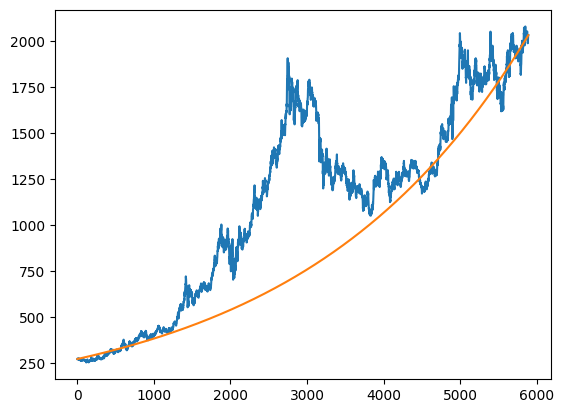

In [71]:
plt.plot(b['Open'].values)
plt.plot(d[0])

In [72]:
b1 = b.drop('Date', axis=1)
b1.reset_index(inplace=True)
b1

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0
1,2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0
2,2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0
3,2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2
4,2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0
...,...,...,...,...,...,...,...
5888,2024-02-19,2015.599976,2015.599976,2015.599976,2015.599976,2015.599976,32
5889,2024-02-20,2015.599976,2029.000000,2015.599976,2027.500000,2027.500000,1326
5890,2024-02-21,2028.199951,2028.199951,2022.300049,2022.300049,2022.300049,15
5891,2024-02-22,2033.199951,2033.199951,2019.699951,2019.699951,2019.699951,964


In [73]:
b2 = b1.loc[:2000, ['Open', 'High', 'Low', 'Close']]

In [74]:
d1 = build_exp_smooth_trend(b2)

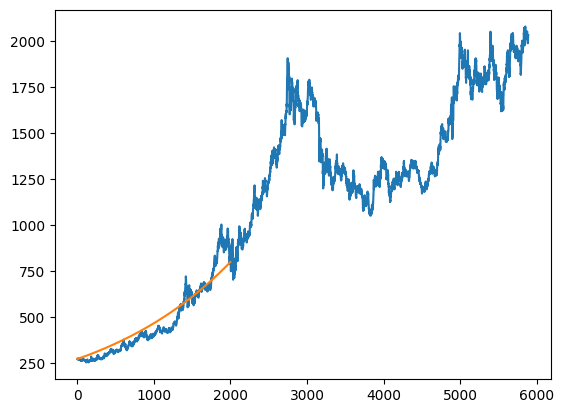

In [75]:
plt.plot(b1['Open'])
plt.plot(d1[0])

In [76]:
b3 = b1.loc[:3000, ['Open', 'High', 'Low', 'Close']]
d2 = build_exp_smooth_trend(b3)

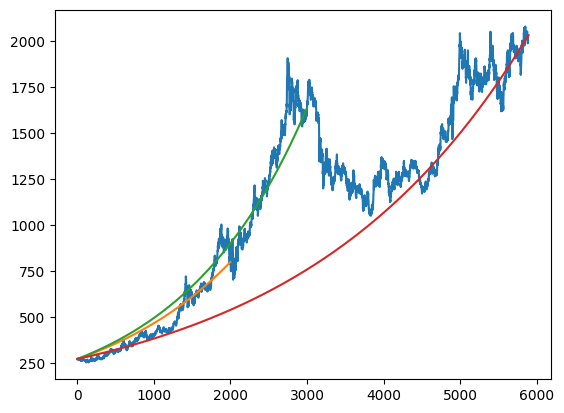

In [77]:
plt.plot(b1['Open'])
plt.plot(d1[0])
plt.plot(d2[0])
plt.plot(d[0])

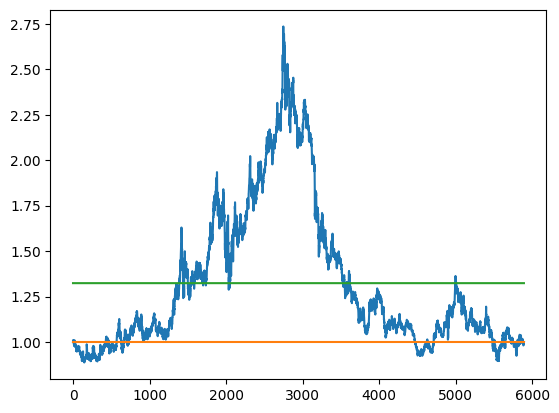

In [78]:
plt.plot(b1['Open'].values / d[0])
plt.plot([1] * len(d[0]))
plt.plot([numpy.mean(b1['Open'].values / d[0])] * len(d[0]))

Text(1.3237052987304787, 1233.0, '1.3237052987304787')

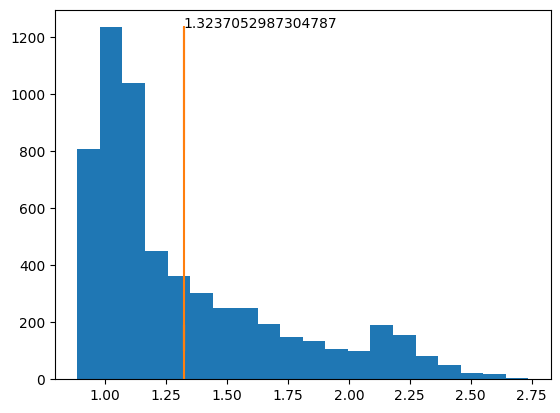

In [79]:
a = plt.hist(b1['Open'].values / d[0], bins=20)
plt.plot([numpy.mean(b1['Open'].values / d[0])] * 20, a[0])
plt.text(x=numpy.mean(b1['Open'].values / d[0]), y=numpy.max(a[0]), s=numpy.mean(b1['Open'].values / d[0]))

In [80]:
#del x

In [81]:
def exp_(x, a_, b_):
    return a_ + b_ * numpy.exp(x)

In [82]:
from scipy.optimize import curve_fit

In [83]:
cf = curve_fit(exp_, xdata=[i / len(b["Open"]) for i in range(len(b['Open']))],
               ydata=b1['Open'].values / numpy.max(b1['Open']))

In [84]:
cf[0]

array([-0.2596222 ,  0.46267188])

In [85]:
curve_exp_fit = numpy.array(
    [exp_(i / len(b1.Open), cf[0][0], cf[0][1]) * numpy.max(b1.Open) for i in range(len(b1.Open))])

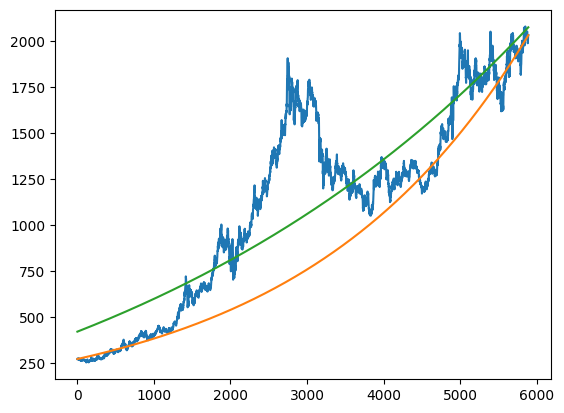

In [86]:
plt.plot(b1['Open'])
plt.plot(d[0])
plt.plot(curve_exp_fit)

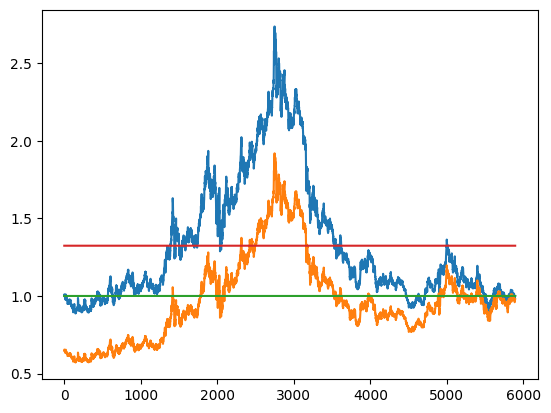

In [87]:
plt.plot(b1['Open'].values / d[0])
plt.plot(b1["Open"] / curve_exp_fit)
plt.plot([1] * len(d[0]))
plt.plot([numpy.mean(b1['Open'].values / d[0])] * len(d[0]))
#plt.plot([numpy.quantile(b1['Open'].values / d[0],0.75)] * len(d[0]))
#plt.plot([numpy.quantile(b1['Open'].values / d[0],0.25)] * len(d[0]))
#plt.plot([numpy.quantile(b1['Open'].values / d[0],0.9)] * len(d[0]))

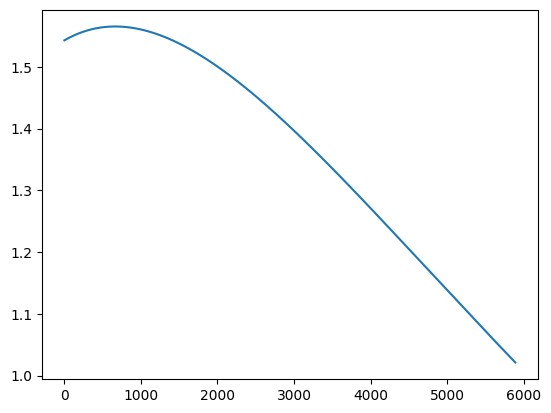

In [88]:
plt.plot((b1['Open'].values / d[0]) / (b1["Open"] / curve_exp_fit))

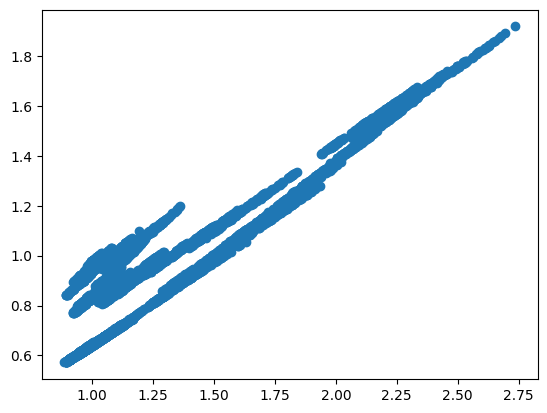

In [89]:
plt.scatter(b1['Open'].values / d[0], b1["Open"] / curve_exp_fit)

In [90]:
numpy.corrcoef(b1['Open'].values / d[0], b1["Open"] / curve_exp_fit)

array([[1.        , 0.92022703],
       [0.92022703, 1.        ]])

In [91]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [92]:
mean_squared_error(b1["Open"], d[0])

133917.76520007357

In [93]:
mean_absolute_error(b1["Open"], d[0])

248.38509326088985

In [94]:
mean_squared_error(b1["Open"], curve_exp_fit)

60825.88302216298

In [95]:
mean_absolute_error(b1["Open"], curve_exp_fit)

189.07596530328732

In [96]:
def build_exp_fit(inp_dataframe):
    try:
        assert type(inp_dataframe) == pandas.core.frame.DataFrame or type(inp_dataframe) == numpy.ndarray or type(
            inp_dataframe) == list
        if type(inp_dataframe) == pandas.core.frame.DataFrame or type(inp_dataframe) == numpy.ndarray:
            assert len(inp_dataframe.shape) == 2
            if type(inp_dataframe) == pandas.core.frame.DataFrame:
                inp_dataframe2 = inp_dataframe.values
            else:
                inp_dataframe2 = inp_dataframe[:]
        else:
            assert len(inp_dataframe[0]) > 1
            inp_dataframe2 = numpy.array(inp_dataframe)

        def exp_fit(x, a_, b_):
            return a_ + b_ * numpy.exp(x)

        fit_data = pandas.DataFrame([])
        for i in range(inp_dataframe2.shape[1]):
            x_data = numpy.array([i for i in range(len(inp_dataframe2))]) / len(inp_dataframe2)
            y_data = inp_dataframe2[:, i] / numpy.max(inp_dataframe2[:, i])
            cfp = curve_fit(exp_fit, x_data, y_data)
            fit_data[i] = numpy.array(
                [exp_fit(j, cfp[0][0], cfp[0][1]) * numpy.max(inp_dataframe2[:, i]) for j in x_data])
        return fit_data
    except Exception as e:
        print(e.__traceback__.tb_lineno, e.__str__(), e)

In [97]:
build_exp_fit(b.loc[:, ['Open', 'High', 'Low', 'Close']])

,0,1,2,3
0,422.668229,424.973464,419.880644,422.553959
1,422.831674,425.137665,420.043372,422.717404
2,422.995146,425.301894,420.206127,422.880877
3,423.158647,425.466150,420.368910,423.044378
4,423.322175,425.630435,420.531721,423.207907
...,...,...,...,...
5888,2075.321423,2085.271210,2065.284743,2075.212297
5889,2075.765335,2085.717175,2065.726708,2075.656211
5890,2076.209322,2086.163216,2066.168748,2076.100199
5891,2076.653384,2086.609333,2066.610863,2076.544263


In [98]:
def residual(inp_dataframe):
    assert type(inp_dataframe) == pandas.core.frame.DataFrame or type(inp_dataframe) == numpy.ndarray or type(
        inp_dataframe) == list
    if type(inp_dataframe) == pandas.core.frame.DataFrame or type(inp_dataframe) == numpy.ndarray:
        assert len(inp_dataframe.shape) == 2
        if type(inp_dataframe) == pandas.core.frame.DataFrame:
            inp_dataframe2 = inp_dataframe.values
        else:
            inp_dataframe2 = inp_dataframe[:]
    else:
        assert len(inp_dataframe[0]) > 1
        inp_dataframe2 = numpy.array(inp_dataframe)

    smooth_dt = build_exp_smooth_trend(inp_dataframe2)
    exp_fit = build_exp_fit(inp_dataframe2)
    return inp_dataframe2 / smooth_dt, inp_dataframe2 / exp_fit

In [99]:
res = residual(b.loc[:, ['Open', 'High', 'Low', 'Close']])

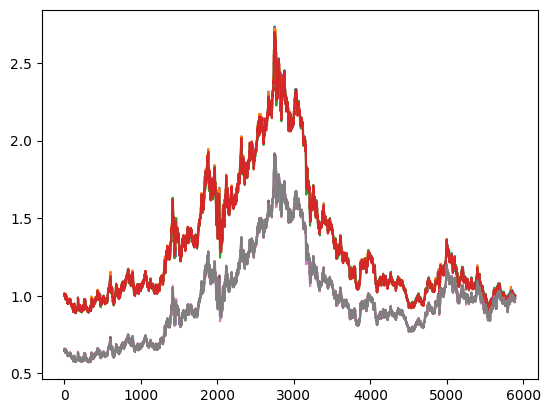

In [100]:
plt.plot(res[0])
plt.plot(res[1])

In [135]:
'''def divide_series_const(list_x1, list_y1, constant):
    p1 = progress_iterable_condition(list_x1)
    p2 = progress_iterable_condition(list_y1)
    assert p1[0] and p2[0]
    list_x2 = p1[1]
    list_y2 = p2[1]
    if len(list_x1) == len(list_y1):
        div = list_y1[:]
        constant.append(list_y1[0])
        for j in range(len(list_x1) - 1):
            divs = []
            for i in range(len(div) - 1):
                d1 = div[i] - div[i + 1]
                d2 = list_x1[i] - list_x1[i + j + 1]
                divs.append((d1 / d2))
            constant.append(divs[0])
            div = divs'''

'def divide_series_const(list_x1, list_y1, constant):\n    p1 = progress_iterable_condition(list_x1)\n    p2 = progress_iterable_condition(list_y1)\n    assert p1[0] and p2[0]\n    list_x2 = p1[1]\n    list_y2 = p2[1]\n    if len(list_x1) == len(list_y1):\n        div = list_y1[:]\n        constant.append(list_y1[0])\n        for j in range(len(list_x1) - 1):\n            divs = []\n            for i in range(len(div) - 1):\n                d1 = div[i] - div[i + 1]\n                d2 = list_x1[i] - list_x1[i + j + 1]\n                divs.append((d1 / d2))\n            constant.append(divs[0])\n            div = divs'

In [136]:
'''def polynomial_interpolation(var_x, list_x, list_y):
    p1 = progress_iterable_condition(list_x)
    p2 = progress_iterable_condition(list_y)
    assert p1[0] and p2[0]
    list_x2 = p1[1]
    list_y2 = p2[1]
    list_const = []
    divide_series_const(list_x2, list_y2, list_const)
    pol = []
    pol.append(list_const[0])
    sent = 1
    sums = pol[0]
    for i in range(1, len(list_const)):
        prod = 1
        for j in range(0, i):
            prod *= (var_x - list_x[j])
        sent *= float(list_const[i] * prod)
        pol.append(sent)
        sums += pol[i]
    return sums'''

'def polynomial_interpolation(var_x, list_x, list_y):\n    p1 = progress_iterable_condition(list_x)\n    p2 = progress_iterable_condition(list_y)\n    assert p1[0] and p2[0]\n    list_x2 = p1[1]\n    list_y2 = p2[1]\n    list_const = []\n    divide_series_const(list_x2, list_y2, list_const)\n    pol = []\n    pol.append(list_const[0])\n    sent = 1\n    sums = pol[0]\n    for i in range(1, len(list_const)):\n        prod = 1\n        for j in range(0, i):\n            prod *= (var_x - list_x[j])\n        sent *= float(list_const[i] * prod)\n        pol.append(sent)\n        sums += pol[i]\n    return sums'

In [144]:
class divide_series_interpolate():
    def __init__(self, xdata, ydata):
        self.list_x = xdata
        self.list_y = ydata
        self.divide_constant = self.divide_series_const(xdata, ydata)

    def divide_series_const(self, list_x1, list_y1):
        constant = []
        p1 = progress_iterable_condition(list_x1)
        p2 = progress_iterable_condition(list_y1)
        assert p1[0] and p2[0]
        list_x2 = p1[1]
        list_y2 = p2[1]
        if len(list_x1) == len(list_y1):
            div = list_y1[:]
            constant.append(list_y1[0])
            for j in range(len(list_x1) - 1):
                divs = []
                for i in range(len(div) - 1):
                    d1 = div[i] - div[i + 1]
                    d2 = list_x1[i] - list_x1[i + j + 1]
                    divs.append((d1 / d2))
                constant.append(divs[0])
                div = divs
        return constant

    def polynomial_interpolation(self, var_x):
        p1 = progress_iterable_condition(self.list_x)
        p2 = progress_iterable_condition(self.list_y)
        assert p1[0] and p2[0]
        list_x2 = p1[1]
        list_y2 = p2[1]
        list_const = self.divide_series_const(list_x2, list_y2)
        pol = []
        pol.append(list_const[0])
        sent = 1
        sums = float(pol[0])
        for i in range(1, len(list_const)):
            prod = 1
            for j in range(0, i):
                prod *= (var_x - list_x2[j])
            sent *= float(list_const[i] * prod)
            pol.append(sent)
            sums += pol[i]
        return sums

In [145]:
b1['Open'][3076]

1710.0999755859375

In [146]:
intp = divide_series_interpolate(b1.Open.index, b1.Open.values)

In [149]:
len(intp.divide_constant)

5893

In [147]:
intp.polynomial_interpolation(3075)

OverflowError: int too large to convert to float

In [118]:
def lagrange(var_x, list_x, list_y):
    p1 = progress_iterable_condition(list_x)
    p2 = progress_iterable_condition(list_y)
    assert p1[0] and p2[0]
    list_x2 = p1[1]
    list_y2 = p2[1]

    def l_i(ind, var_x, list_x1):
        product = 1
        prod1 = 1
        prod2 = 1
        for i in range(len(list_x1)):
            if i != ind:
                prod1 *= (var_x - list_x1[i])
                prod2 *= (list_x1[ind] - list_x1[i])
        product = float(prod1 / prod2)
        return product

    sums = 0
    for i in range(len(list_x2)):
        sums += l_i(i, var_x, list_x2) * list_y2[i]
    return sums

In [119]:
lagrange(3076, list_x=b1.Open.index, list_y=b1.Open.values)

1710.0999755859375

In [120]:
lagrange(3075, list_x=b1.Open.index, list_y=b1.Open.values)

1710.0

In [114]:
lagrange(5893, list_x=b1.Open.index, list_y=b1.Open.values)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3520\3289934017.py:19: RuntimeWarning: overflow encountered in scalar multiply
  sums += l_i(i, var_x, list_x2)*list_y2[i]


OverflowError: integer division result too large for a float

In [121]:
from scipy.interpolate import interp1d

In [123]:
f = interp1d(b1.Open.index, b1.Open.values, 'cubic')

In [124]:
f(b1.Open.index)

array([ 273.8999939 ,  274.79998779,  277.        , ..., 2028.19995117,
       2033.19995117, 2034.09997559])

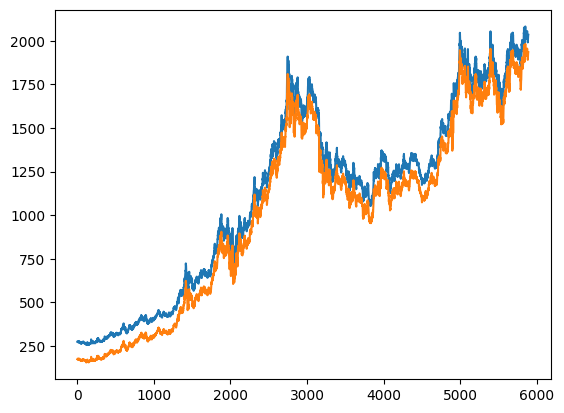

In [133]:
plt.plot(b1.Open.values)
plt.plot(f(b1.Open.index) - 100)

In [128]:
f(3075)

array(1710.)

In [129]:
b1.Open[3075]

1710.0

In [130]:
f(3076)

array(1710.09997559)

In [131]:
b1.Open[3076]

1710.0999755859375

In [132]:
f(3076.5)

array(1709.0694103)

In [16]:
a

,Date,Open,High,Low,Close,Final,Volume,Value,No,Ticker,Name,Market
J-Date,,,,,,,,,,,,
1400-11-20,2022-02-09,17726,21666,17726,17800,21429,299999591,6428779475028,1264932,فزر,پویا زرکان آق دره,فرابورس
1400-11-23,2022-02-12,22500,22500,22500,22500,22500,5647336,127065060000,29757,فزر,پویا زرکان آق دره,فرابورس
1400-11-24,2022-02-13,23600,23600,23600,23600,23600,8205025,193638590000,34375,فزر,پویا زرکان آق دره,فرابورس
1400-11-25,2022-02-14,24750,24750,24750,24750,24750,8782700,217371825000,38520,فزر,پویا زرکان آق دره,فرابورس
1400-11-27,2022-02-16,25950,25950,24850,25300,25700,129477173,3326995414950,526252,فزر,پویا زرکان آق دره,فرابورس
...,...,...,...,...,...,...,...,...,...,...,...,...
1402-12-05,2024-02-24,41000,41200,39800,40600,40350,11935180,481775675150,3990,فزر,پویا زرکان آق دره,فرابورس
1402-12-07,2024-02-26,40500,41200,39500,39900,40200,3933553,158097146000,2859,فزر,پویا زرکان آق دره,فرابورس
1402-12-08,2024-02-27,40000,40800,39600,39850,39950,4098412,163747065650,2436,فزر,پویا زرکان آق دره,فرابورس


In [33]:
a = a.loc[:, ['Open', 'High', 'Low', 'Close']]

In [65]:
def exp_smooth_final_fit(inp_dataframe):
    assert type(inp_dataframe) == pandas.core.frame.DataFrame or type(inp_dataframe) == numpy.ndarray or type(
        inp_dataframe) == list
    if type(inp_dataframe) == pandas.core.frame.DataFrame or type(inp_dataframe) == numpy.ndarray:
        assert len(inp_dataframe.shape) == 2
        if type(inp_dataframe) == pandas.core.frame.DataFrame:
            inp_dataframe2 = inp_dataframe.values
        else:
            inp_dataframe2 = inp_dataframe[:]
    else:
        assert len(inp_dataframe[0]) > 1
        inp_dataframe2 = numpy.array(inp_dataframe)
    smooth_dt = build_exp_smooth_trend(inp_dataframe)
    smooth_dt = smooth_dt.values
    res = inp_dataframe2 / smooth_dt
    mean_res = [mean_exp(res[:, i]) for i in range(res.shape[1])]
    #return mean_res
    return numpy.array([smooth_dt[:, i] * mean_res[i] for i in range(res.shape[1])]).T

In [66]:
sm = exp_smooth_final_fit(a)

In [67]:
sm

array([[21941.81823922, 24026.30146691, 21493.03264677, 21317.38604015],
       [21979.85840079, 24060.80207619, 21530.2947563 , 21356.88815866],
       [22017.96451195, 24095.35222669, 21567.62146652, 21396.46347645],
       ...,
       [49527.09594021, 47160.76720555, 48514.09661393, 50889.11947555],
       [49612.96023418, 47228.48779105, 48598.20468799, 50983.41940635],
       [49698.97338964, 47296.30562004, 48682.45857881, 51077.89407935]])

In [18]:
import matplotlib.pyplot as plt

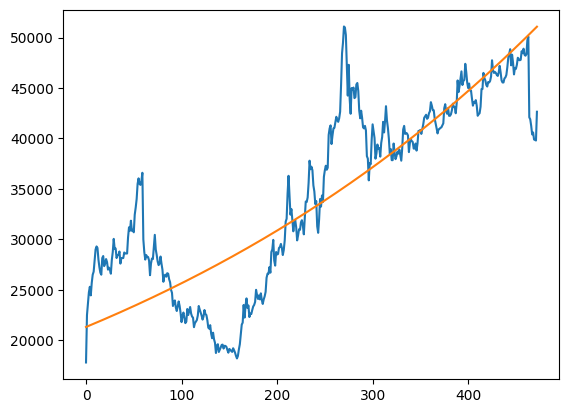

In [73]:
plt.plot(a['Close'].values)
plt.plot(sm[:, 3])

In [7]:
np.random.random(1) * (28.45 - 19.32) + 19.32

array([23.02549406])

In [8]:
np.array([1, 2, 3, 4, 5]) * np.array([1, 2, 3, 4, 5])

array([ 1,  4,  9, 16, 25])

In [6]:
a

,Date,Open,High,Low,Close,Final,Volume,Value,No,Ticker,Name,Market
J-Date,,,,,,,,,,,,
1400-11-20,2022-02-09,17726,21666,17726,17800,21429,299999591,6428779475028,1264932,فزر,پویا زرکان آق دره,فرابورس
1400-11-23,2022-02-12,22500,22500,22500,22500,22500,5647336,127065060000,29757,فزر,پویا زرکان آق دره,فرابورس
1400-11-24,2022-02-13,23600,23600,23600,23600,23600,8205025,193638590000,34375,فزر,پویا زرکان آق دره,فرابورس
1400-11-25,2022-02-14,24750,24750,24750,24750,24750,8782700,217371825000,38520,فزر,پویا زرکان آق دره,فرابورس
1400-11-27,2022-02-16,25950,25950,24850,25300,25700,129477173,3326995414950,526252,فزر,پویا زرکان آق دره,فرابورس
...,...,...,...,...,...,...,...,...,...,...,...,...
1402-12-09,2024-02-28,39850,40700,39750,39800,39900,4355890,173818112250,2219,فزر,پویا زرکان آق دره,فرابورس
1402-12-12,2024-03-02,40150,42650,40150,42650,41800,7903260,330312984600,2508,فزر,پویا زرکان آق دره,فرابورس
1402-12-13,2024-03-03,43000,43850,41950,42100,42600,6532632,278300586750,2961,فزر,پویا زرکان آق دره,فرابورس


In [7]:
from my_func_pkg import sample_fractal_on_all_data

In [8]:
y = a.Close.x = a.Close.values
x = np.arange(len(y))

In [11]:
sf = sample_fractal_on_all_data(x, y, 100)

100%|██████████| 98/98 [00:23<00:00,  4.26it/s]


In [14]:
sf[1][-1]

array([123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
       201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222])

In [15]:
from my_func_pkg import build_from_sample_all_data

In [16]:
z = build_from_sample_all_data(sf[1][-1], y[sf[1][-1]], x, y, kind='adj')

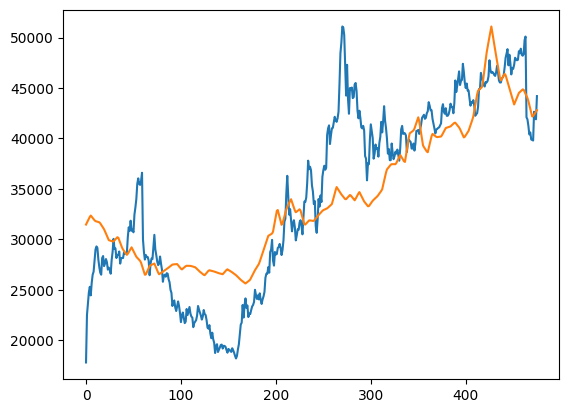

In [19]:
plt.plot(y)
plt.plot(z)

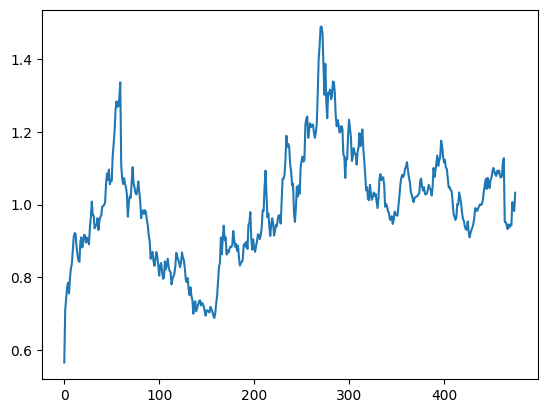

In [20]:
plt.plot(y / z)

In [21]:
x1 = np.linspace(0, 2 * np.pi, 50)

In [22]:
x1

array([0.        , 0.12822827, 0.25645654, 0.38468481, 0.51291309,
       0.64114136, 0.76936963, 0.8975979 , 1.02582617, 1.15405444,
       1.28228272, 1.41051099, 1.53873926, 1.66696753, 1.7951958 ,
       1.92342407, 2.05165235, 2.17988062, 2.30810889, 2.43633716,
       2.56456543, 2.6927937 , 2.82102197, 2.94925025, 3.07747852,
       3.20570679, 3.33393506, 3.46216333, 3.5903916 , 3.71861988,
       3.84684815, 3.97507642, 4.10330469, 4.23153296, 4.35976123,
       4.48798951, 4.61621778, 4.74444605, 4.87267432, 5.00090259,
       5.12913086, 5.25735913, 5.38558741, 5.51381568, 5.64204395,
       5.77027222, 5.89850049, 6.02672876, 6.15495704, 6.28318531])

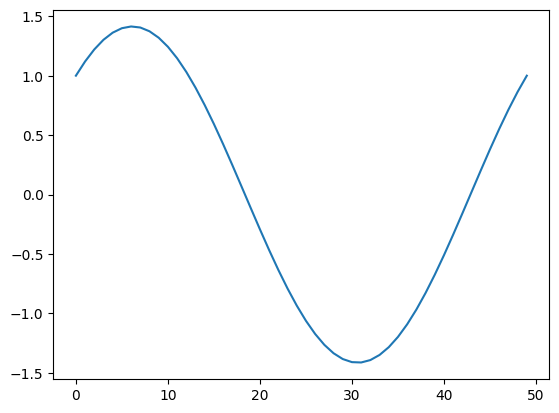

In [24]:
plt.plot(np.sin(x1) + np.cos(x1))

In [25]:
def f1(x_1, a, b, c):
    return a + b * np.sin(x_1 + c)

In [26]:
y1=y/z
x1=np.arange(len(y1))

In [30]:
p=curve_fit(f1,x1,y1)

In [31]:
p[0]

array([ 0.99726792, -0.0034224 ,  1.07275622])

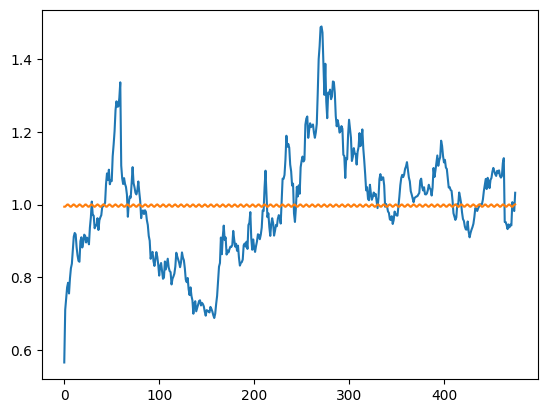

In [32]:
plt.plot(y1)
plt.plot(f1(x1,p[0][0],p[0][1],p[0][2]))

In [33]:
rsf=sample_fractal_on_all_data(x1,y1,int(len(y1)/10))

100%|██████████| 45/45 [00:11<00:00,  3.78it/s]


In [34]:
z1=build_from_sample_all_data(rsf[1][-1],y1[rsf[1][-1]],x1,y1)

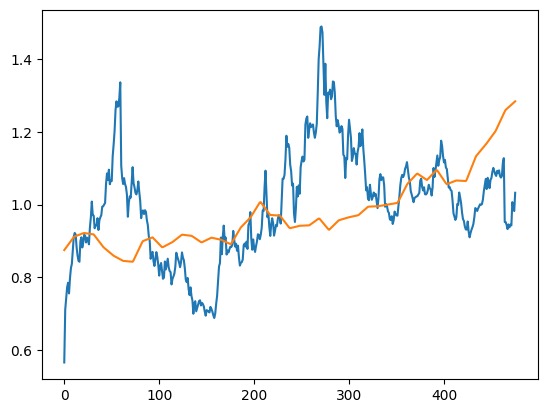

In [35]:
plt.plot(y1)
plt.plot(z1)